This Python code translates the R code (the example_acm.R)  The code creates a scatter plot that displays an adaptive comfort model based on the ASHRAE Global Thermal Comfort Database II. The plot shows the relationship between outdoor temperature and neutral temperature for different building cooling types: Air Conditioned, Mixed Mode, and Naturally Ventilated. </br>

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from matplotlib.ticker import FormatStrFormatter


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Data Preparation

In [2]:
# Read metadata from Github
url_meta = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv"
df_meta = pd.read_csv(url_meta)

# Read database from Github
url_measurements = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz"
df_measurements = pd.read_csv(url_measurements, low_memory=False)

In [3]:
df_measurements

,index,record_id,building_id,timestamp,season,subject_id,age,gender,ht,wt,...,rh_out,t_out_monthly,t_out_isd,rh_out_isd,set,pmv,ppd,pmv_ce,ppd_ce,t_mot_isd
0,0,1,1,1995-05-18T00:00:00Z,winter,10,NaN,female,NaN,NaN,...,99.1,NaN,16.295833,86.837514,28.1,0.50,10.2,0.38,8.0,17.4
1,1,2,1,1995-05-18T00:00:00Z,winter,14,NaN,female,NaN,NaN,...,99.1,NaN,16.295833,86.837514,27.2,0.40,8.4,0.40,8.4,17.4
2,2,3,1,1995-05-18T00:00:00Z,winter,15,NaN,female,NaN,NaN,...,99.1,NaN,16.295833,86.837514,24.8,-0.07,5.1,-0.07,5.1,17.4
3,3,4,1,1995-05-18T00:00:00Z,winter,17,NaN,female,NaN,NaN,...,99.1,NaN,16.295833,86.837514,25.5,0.31,7.0,0.14,5.4,17.4
4,4,5,1,1995-05-18T00:00:00Z,winter,21,NaN,male,NaN,NaN,...,99.1,NaN,16.295833,86.837514,26.0,0.05,5.0,-0.06,5.1,17.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109028,110065,110066,809,2014-06-02T00:00:00Z,hot/wet,NaN,NaN,NaN,NaN,NaN,...,NaN,28.8,28.316667,82.059739,NaN,NaN,NaN,NaN,NaN,28.0
109029,110066,110067,809,2014-06-02T00:00:00Z,hot/wet,NaN,NaN,NaN,NaN,NaN,...,NaN,28.8,28.316667,82.059739,NaN,NaN,NaN,NaN,NaN,28.0
109030,110067,110068,809,2014-06-02T00:00:00Z,hot/wet,NaN,NaN,NaN,NaN,NaN,...,NaN,28.8,28.316667,82.059739,NaN,NaN,NaN,NaN,NaN,28.0
109031,110068,110069,809,2014-06-02T00:00:00Z,hot/wet,NaN,NaN,NaN,NaN,NaN,...,NaN,28.8,28.316667,82.059739,NaN,NaN,NaN,NaN,NaN,28.0


To conduct adaptive thermal model analysis, we need concurrent observations of indoor air temperature, thermal sensation vote, and outdoor mean monthly temperature. However, here here the orignial R code (Python version) also requires relative humidity data.

In [4]:
# remove nan values in Ta, thermal_sensation, and t_out_isd or t_out
df_acm = df_measurements.loc[(~df_measurements['ta'].isna()) &
                              (~df_measurements['thermal_sensation'].isna()) &
                              (~(df_measurements['t_out_isd'].isna()) | ~(df_measurements['t_out'].isna()))].copy()
print('number of rows that have required data for acm:', len(df_acm))
print('number of buildings that have required data for acm:', len(df_acm.building_id.unique()))

# Fill the missing values in the outdoor temperature column
df_acm.loc[:, 't_out_combined'] = df_acm.loc[:, 't_out_isd'].fillna(df_acm.loc[:, 't_out'])

# Remove original temperature columns
df_acm = df_acm.drop(columns=['t_out_isd', 't_out'])

# Merge metadata and databased by office buildings
df_acm = df_acm.merge(df_meta[['building_id', 'region', 'building_type', 'cooling_type', 'records', 'climate']], on='building_id', how='left')
df_acm = df_acm[df_acm['building_type'] == 'office']
df_acm = df_acm.drop(columns=['building_type'])
print('number of office buildings that have required data for acm:', len(df_acm.building_id.unique()))
print('number of rows (office) that have required data for acm:', len(df_acm))


number of rows that have required data for acm: 78515
number of buildings that have required data for acm: 743
number of office buildings that have required data for acm: 309
number of rows (office) that have required data for acm: 52265


## Calculate the neutral temperature for each building
The orginal R code evalue the p-value of intercept

In [9]:

def run_lm(bldg):
    try:
        lm_result = smf.ols(formula='ta ~ thermal_sensation', data=bldg).fit()
        # check whether the slope is significant
        if lm_result.pvalues['Intercept'] < 0.05:
            return lm_result.params['Intercept']
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

df_models = df_acm.groupby('building_id').apply(run_lm).reset_index()
df_models.columns = ['building_id', 'neutral_temp']
df_models = df_models.merge(df_meta[['building_id', 'records', 'cooling_type', 'region', 'climate', 'city', 'year']], on='building_id', how='left')
df_models['t_out_mean'] = df_acm.groupby('building_id')['t_out_combined'].mean().values
# add season column to df_models from df_acm grouped by building_id
df_models['season'] = df_acm.groupby('building_id')['season'].first().values
df_models['timestamp'] = df_acm.groupby('building_id')['timestamp'].first().values

# get rid of all nan values in the neutral_temp column
df_models = df_models[~df_models['neutral_temp'].isna()]
df_models


,building_id,neutral_temp,records,cooling_type,region,climate,city,year,t_out_mean,season,timestamp
0,1,22.585738,170,mixed mode,oceania,humid subtropical,sydney,1995,15.296857,winter,1995-05-18T00:00:00Z
1,2,22.058339,83,air conditioned,oceania,humid subtropical,sydney,1996,13.995833,winter,1996-05-28T00:00:00Z
2,3,23.142187,85,air conditioned,americas,humid midlatitude,grand rapids,1992,0.583480,winter,1992-01-29T00:00:00Z
3,4,23.646082,137,mixed mode,oceania,humid subtropical,sydney,1995,19.280947,summer,1995-02-27T00:00:00Z
4,5,22.071788,128,air conditioned,americas,mediterranean,auburn,1993,9.048210,winter,1993-03-15T00:00:00Z
...,...,...,...,...,...,...,...,...,...,...,...
304,763,20.837842,134,naturally ventilated,europe,warm-summer mediterranean,porto,1998,9.983256,winter,1998-11-12T00:00:00Z
305,771,23.439683,161,air conditioned,europe,temperate oceanic,malmo,1998,15.119837,summer,1998-08-17T00:00:00Z
306,772,23.082808,94,air conditioned,europe,temperate oceanic,malmo,1998,2.571260,winter,1998-11-09T00:00:00Z
307,779,28.210619,118,air conditioned,asia,humid subtropical,tokyo,2006,28.855652,summer,None


## Weigted regression on NV/AC/MM buildings

In [10]:
filtered_df = df_models[(df_models['t_out_mean'] >= 10) & (df_models['t_out_mean'] <= 33) &
                        (df_models['neutral_temp'] > 17) & (df_models['neutral_temp'] < 32)].copy()

filtered_df['cooling_type'] = filtered_df['cooling_type'].str.title()
filtered_df['point_size'] = filtered_df['records']
# only keep naturally ventilated and air conditioned buildings
filtered_dfac = filtered_df[(filtered_df['cooling_type'] == 'Air Conditioned')]
filtered_dfnv = filtered_df[(filtered_df['cooling_type'] == 'Naturally Ventilated')]

In [20]:
filtered_dfac

,building_id,neutral_temp,records,cooling_type,region,climate,city,year,t_out_mean,season,timestamp,point_size
1,2,22.058339,83,Air Conditioned,oceania,humid subtropical,sydney,1996,13.995833,winter,1996-05-28T00:00:00Z,83
5,6,22.694425,96,Air Conditioned,americas,mediterranean,san ramon,1993,17.668114,summer,1993-07-19T00:00:00Z,96
6,7,22.304064,152,Air Conditioned,americas,mediterranean,san ramon,1991,14.604240,winter,1991-04-08T00:00:00Z,152
8,9,23.089425,111,Air Conditioned,americas,mediterranean,antioch,1995,11.248123,winter,1995-01-23T00:00:00Z,111
9,10,23.994937,17,Air Conditioned,europe,west coast marine,south wales,1992,15.800000,summer,1992-07-16T00:00:00Z,17
...,...,...,...,...,...,...,...,...,...,...,...,...
296,737,24.375203,99,Air Conditioned,asia,tropical,shah alam,2015,28.469928,cool/dry,2015-03-05T00:00:00Z,99
297,738,24.267827,387,Air Conditioned,asia,tropical,shah alam,2015,28.905322,hot/wet,2015-04-06T00:00:00Z,387
298,739,23.505263,56,Air Conditioned,asia,tropical,singapore,2015,25.815476,cool/dry,2015-01-08T00:00:00Z,56
305,771,23.439683,161,Air Conditioned,europe,temperate oceanic,malmo,1998,15.119837,summer,1998-08-17T00:00:00Z,161


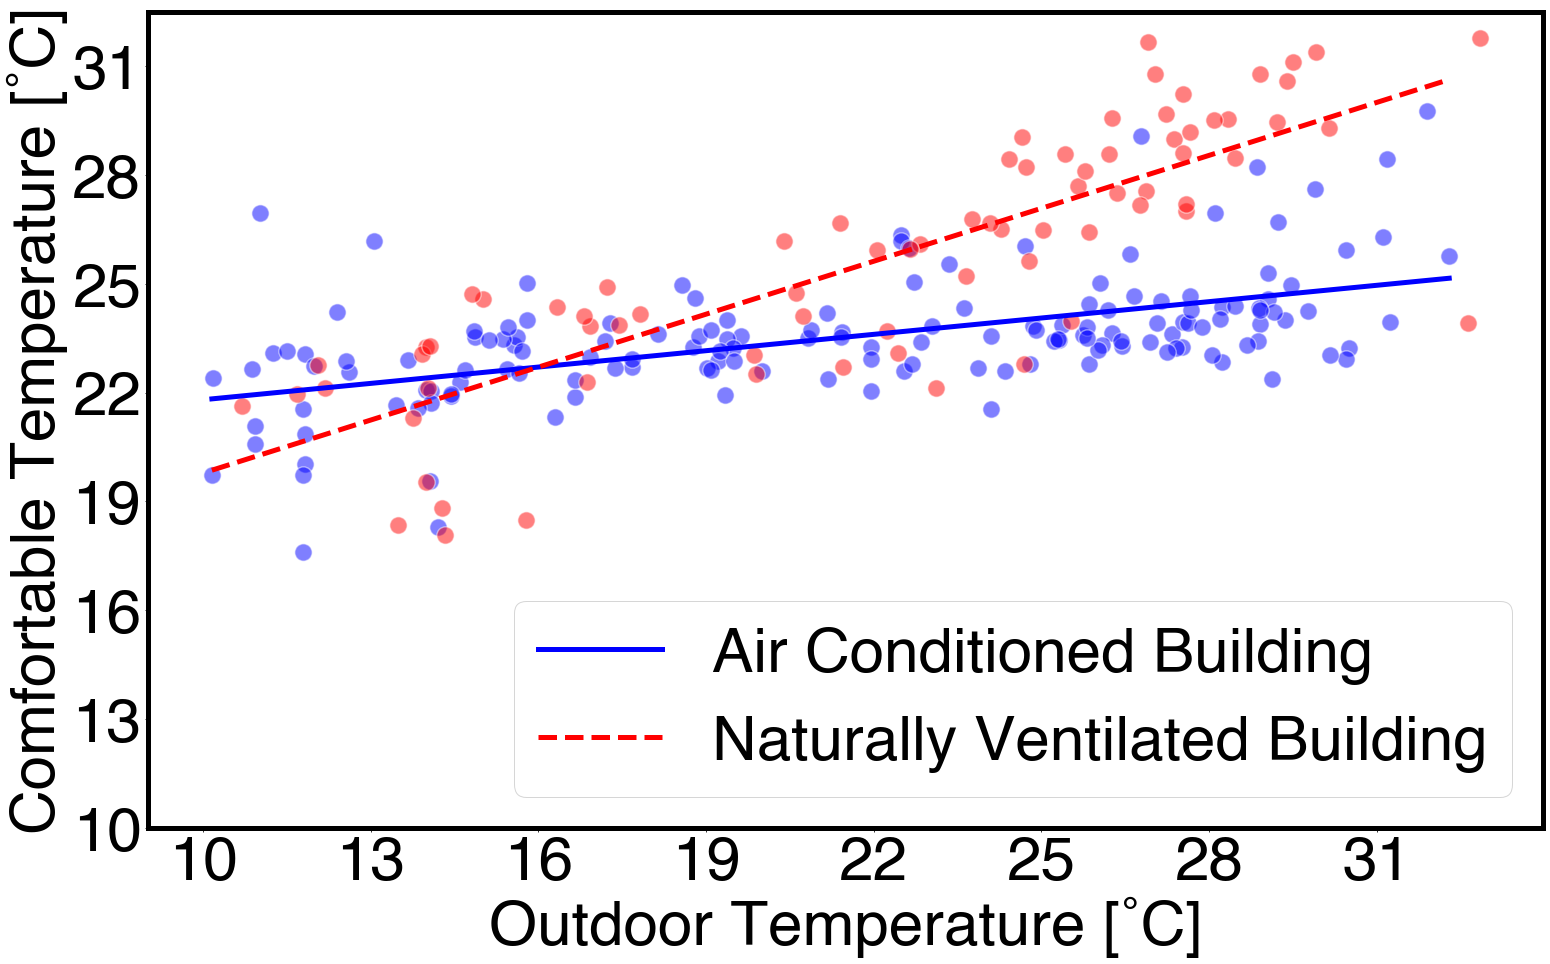

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np

# Define a custom function to draw the regression line
def regression_line(x, model):
    return model.params[0] + model.params[1] * x

# Set the font to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# Create a figure and axis
fig, ax = plt.subplots(figsize=(25, 15))

# Perform regression and plot lines for each cooling type
lm_ac = smf.ols(formula='neutral_temp ~ t_out_mean', data=filtered_dfac).fit()
lm_nv = smf.ols(formula='neutral_temp ~ t_out_mean', data=filtered_dfnv).fit()

x_values = np.linspace(filtered_dfac['t_out_mean'].min(), filtered_dfac['t_out_mean'].max(), 100)
y_values_ac = regression_line(x_values, lm_ac)
y_values_nv = regression_line(x_values, lm_nv)

# Plot the lines with different colors
ax.plot(x_values, y_values_ac, color='blue', linestyle='-', linewidth=5, label='Air Conditioned Building')
ax.plot(x_values, y_values_nv, color='red', linestyle='--', linewidth=5, label='Naturally Ventilated Building')

# Plot scatter points with the same size for all points
sns.scatterplot(x='t_out_mean', y='neutral_temp', data=filtered_dfac,
                ax=ax, color='blue', alpha=0.5, legend=False, s=300)
sns.scatterplot(x='t_out_mean', y='neutral_temp', data=filtered_dfnv,
                ax=ax, color='red', alpha=0.5, legend=False, s=300)

# Set the y-axis label of the right axis
ax.set_ylabel('Comfortable Temperature [˚C]', fontsize=62)
ax.set_xlabel('Outdoor Temperature [˚C]', fontsize=62)

# Increase font size of tick labels and legend
ax.tick_params(axis='both', labelsize=62)
ax.legend(prop={'size': 62}, loc='lower right')

# Set the intervals and labels on the x-axis
start_value = 10  # Specify the desired starting value for the x-axis
end_value = 31 # Maximum value from the data
step = 3  # Specify the step between tick positions
xticks = np.arange(start_value, end_value + 1, step)
plt.xticks(xticks)

# Set the intervals and labels on the x-axis
start_value = 10  # Specify the desired starting value for the x-axis
end_value = 31 # Maximum value from the data
step = 3  # Specify the step between tick positions
yticks = np.arange(start_value, end_value + 1, step)
plt.yticks(yticks)


# Set the title
# plt.title('Adaptive Comfort Model using ASHRAE Global Thermal Comfort Database 2\n', fontsize=62)

# Increase line size of the frame
for spine in ax.spines.values():
    spine.set_linewidth(5)

plt.show()


In [23]:
lm_ac.params

Intercept     20.299105
t_out_mean     0.150320
dtype: float64

In [24]:
lm_nv.params

Intercept     14.914006
t_out_mean     0.486764
dtype: float64

Regression results for natural ventilated buildings

In [ ]:
# Filter the data for naturally ventilated buildings
naturally_ventilated = df_models[df_models['cooling_type'] == 'naturally ventilated']

# Run weighted linear regression between neutral_temp and t_out_mean
lm_w_nv = smf.ols(formula='neutral_temp ~ t_out_mean', weights=naturally_ventilated.records, data=naturally_ventilated).fit()

# Print the summary of the linear regression
print(lm_w_nv.summary())


                            OLS Regression Results                            
Dep. Variable:           neutral_temp   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.675e+04
Date:                Thu, 04 May 2023   Prob (F-statistic):          2.73e-118
Time:                        11:32:21   Log-Likelihood:                -204.03
No. Observations:                  87   AIC:                             412.1
Df Residuals:                      85   BIC:                             417.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.8851      0.820     19.380      0.0

Regression results for mixed mode buildings

In [ ]:
# Filter the data for mix mode buildings
mixed_mode = df_models[df_models['cooling_type'] == 'mixed mode']

# Run linear regression between neutral_temp and t_out_mean
lm_w_mm = smf.ols(formula='neutral_temp ~ t_out_mean', weights=mixed_mode.records, data=mixed_mode).fit()

# Print the summary of the linear regression
print(lm_w_mm.summary())

                            OLS Regression Results                            
Dep. Variable:           neutral_temp   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.935e+04
Date:                Thu, 04 May 2023   Prob (F-statistic):           3.84e-45
Time:                        11:32:11   Log-Likelihood:                -54.866
No. Observations:                  31   AIC:                             113.7
Df Residuals:                      29   BIC:                             116.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.2096      0.700     30.292      0.0

Regression results for air_conditioned buildings

In [ ]:
# Filter the data for naturally ventilated buildings
air_conditioned = df_models[df_models['cooling_type'] == 'air conditioned']

# Run linear regression between neutral_temp and t_out_mean
lm_w_ac = smf.ols(formula='neutral_temp ~ t_out_mean', weights=air_conditioned.records, data=air_conditioned).fit()

# Print the summary of the linear regression
print(lm_w_ac.summary())

                            OLS Regression Results                            
Dep. Variable:           neutral_temp   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 1.117e+04
Date:                Thu, 04 May 2023   Prob (F-statistic):          6.22e-164
Time:                        11:31:54   Log-Likelihood:                -362.29
No. Observations:                 182   AIC:                             728.6
Df Residuals:                     180   BIC:                             735.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.4932      0.232     96.981      0.0

## Select buildings that have thermal sensation distribution near neutral

The way of calculating the neutral temperature is wrong. For example, if all the data distributed around the hot sensation or high temperature area, it don't mean that their neutral temperature can be extropolated as the linear relationship developed at the extreme conditions . The thermal sensations would be always hot around the extreme conditions. e.g. people all feel hot at both 30 and 35, so the linear regression is flat, but that doesn't mean their neutral temperature is 30\
understanding the evenness of the distribution (how evenly data points are spread across the range), we can consider measures of uniformity. One such measure is the Chi-Square Goodness of Fit test. This test essentially measures the divergence of the observed data from an expected uniform distribution.


The mean value of the distribution should be 0, and the standard deviation should be small (which excludes extreme thermal sensations)

In [ ]:
# Calculate mean and standard deviation for each building
building_stats = df_acm.groupby('building_id')['thermal_sensation'].agg(['mean', 'std'])

# Set your desired threshold for mean and standard deviation
mean_threshold = 0.5  # Change this value as needed
std_threshold = 1  # Change this value as needed

# Keep the buildings based on the calculated mean and standard deviation
qualifed_building_ids = building_stats[(building_stats['mean'].abs() < mean_threshold) & 
                                       (building_stats['std'] < std_threshold)].index

# Filter the original DataFrame to include only the buildings that meet the criteria
qualifed_df = df_acm[df_acm['building_id'].isin(qualifed_building_ids)]
print('number of office buildings that were used for adaptive thermal comfort analysis:', len(df_acm.building_id.unique()))
print('number of office buildings that have qualifed thermal sensation distribution:', len(qualifed_df.building_id.unique()))


In [ ]:
#plot the distribution of ta for each building
# Get unique building ids
building_ids = df_acm['building_id'].unique()

# Calculate the number of rows needed for subplots based on the number of buildings
n_rows = int(np.ceil(len(building_ids) / 4))  # Adjust the denominator to change number of columns

# Determine common bin edges for all plots
min_val = df_acm['ta'].min()
max_val = df_acm['ta'].max()
bins = np.linspace(min_val, max_val, 30)  # Adjust the number of bins as needed

fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows*5))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axis array to easily iterate over it

for ax, building in zip(axes, building_ids):
    sns.histplot(df_acm[df_acm['building_id'] == building]['ta'], ax=ax, kde=True, bins=bins)
    ax.set_title(f'Building {building}')

# Remove empty subplots
for ax in axes[len(building_ids):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get unique building ids
building_ids = df_acm['building_id'].unique()

# Calculate the number of rows needed for subplots based on the number of buildings
n_rows = int(np.ceil(len(building_ids) / 4))  # Adjust the denominator to change number of columns

# Determine common bin edges for all plots
min_val = df_acm['thermal_sensation'].min()
max_val = df_acm['thermal_sensation'].max()
bins = np.linspace(min_val, max_val, 7)  # Adjust the number of bins as needed

fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows*5))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axis array to easily iterate over it

for ax, building in zip(axes, building_ids):
    sns.histplot(df_acm[df_acm['building_id'] == building]['thermal_sensation'], ax=ax, kde=True, bins=bins)
    ax.set_title(f'Building {building}')

# Remove empty subplots
for ax in axes[len(building_ids):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

### weigted regression on 260 qualifed buildings (mu.abs <1. sigma<1.5)

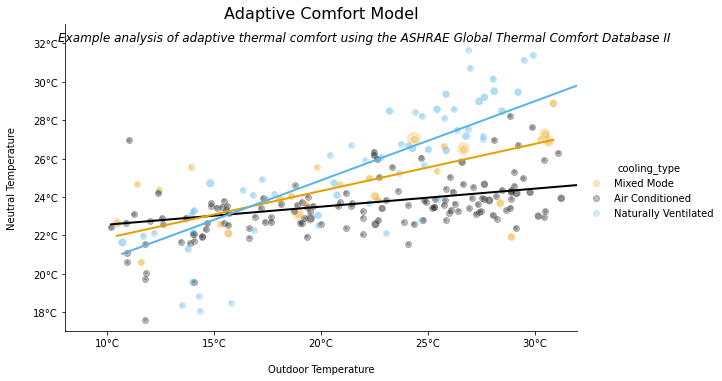

In [ ]:
qualifed_df = df_models[df_models['building_id'].isin(qualifed_building_ids)]

filtered_df = qualifed_df[(qualifed_df['t_out_mean'] >= 10) & (qualifed_df['t_out_mean'] <= 33) &
                        (qualifed_df['neutral_temp'] > 17) & (qualifed_df['neutral_temp'] < 32)].copy()

filtered_df['cooling_type'] = filtered_df['cooling_type'].str.title()
filtered_df['point_size'] = filtered_df['records']

# Define a custom function to draw the weighted regression line
def weighted_regression_line(x, model):
    return model.params[0] + model.params[1] * x

colors = {"Air Conditioned": "#000000", "Mixed Mode": "#E69F00", "Naturally Ventilated": "#56B4E9"}

lm = sns.lmplot(data=filtered_df, x='t_out_mean', y='neutral_temp', hue='cooling_type', 
                palette=colors, scatter_kws={'alpha': 0.25}, 
                height=5, aspect=1.6, fit_reg=False)

# Add point_size directly to the scatterplot
sns.scatterplot(data=filtered_df, x='t_out_mean', y='neutral_temp', hue='cooling_type', 
                size='point_size', sizes=(10, 200), legend=False, 
                palette=colors, alpha=0.25, ax=lm.ax)

# Fit weighted linear regression and plot the lines for each cooling_type
for cooling_type, color in colors.items():
    sub_df = filtered_df[filtered_df['cooling_type'] == cooling_type]
    wlm = smf.wls(formula='neutral_temp ~ t_out_mean', data=sub_df, weights=sub_df['point_size']).fit()
    x_values = np.linspace(sub_df['t_out_mean'].min(), sub_df['t_out_mean'].max(), 100)
    y_values = weighted_regression_line(x_values, wlm)
    lm.ax.plot(x_values, y_values, color=color, linewidth=2)

lm.ax.set_xlim(8, 32)
lm.ax.set_ylim(17, 33)
lm.ax.set_xlabel('\nOutdoor Temperature')
lm.ax.set_ylabel('Neutral Temperature\n')
lm.ax.xaxis.set_major_formatter(FormatStrFormatter('%d°C'))
lm.ax.yaxis.set_major_formatter(FormatStrFormatter('%d°C'))

# Annotations
lm.ax.annotate("Lower 80%", xy=(33.7, 24.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Lower 90%", xy=(33.7, 25.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Upper 90%", xy=(33.7, 28.0), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Upper 80%", xy=(33.7, 30.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')


plt.title('Adaptive Comfort Model', fontsize=16)
plt.suptitle('Example analysis of adaptive thermal comfort using the ASHRAE Global Thermal Comfort Database II', fontsize=12, fontstyle='italic', y=0.95)
plt.show()

### weigted regression on 131 qualifed buildings (mu.abs <1 sigma<1)

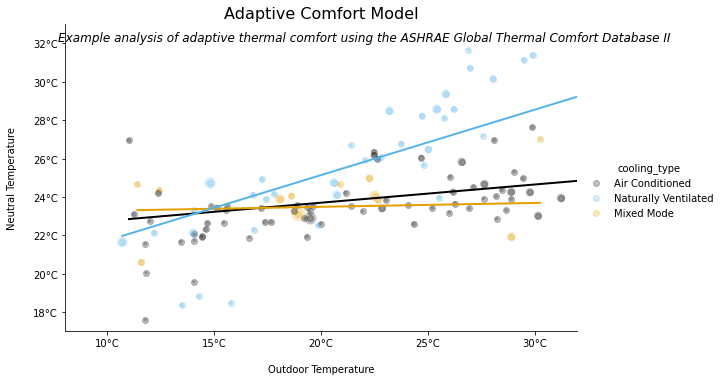

In [ ]:
qualifed_df = df_models[df_models['building_id'].isin(qualifed_building_ids)]

filtered_df = qualifed_df[(qualifed_df['t_out_mean'] >= 10) & (qualifed_df['t_out_mean'] <= 33) &
                        (qualifed_df['neutral_temp'] > 17) & (qualifed_df['neutral_temp'] < 32)].copy()

filtered_df['cooling_type'] = filtered_df['cooling_type'].str.title()
filtered_df['point_size'] = filtered_df['records']

# Define a custom function to draw the weighted regression line
def weighted_regression_line(x, model):
    return model.params[0] + model.params[1] * x

colors = {"Air Conditioned": "#000000", "Mixed Mode": "#E69F00", "Naturally Ventilated": "#56B4E9"}

lm = sns.lmplot(data=filtered_df, x='t_out_mean', y='neutral_temp', hue='cooling_type', 
                palette=colors, scatter_kws={'alpha': 0.25}, 
                height=5, aspect=1.6, fit_reg=False)

# Add point_size directly to the scatterplot
sns.scatterplot(data=filtered_df, x='t_out_mean', y='neutral_temp', hue='cooling_type', 
                size='point_size', sizes=(10, 200), legend=False, 
                palette=colors, alpha=0.25, ax=lm.ax)

# Fit weighted linear regression and plot the lines for each cooling_type
for cooling_type, color in colors.items():
    sub_df = filtered_df[filtered_df['cooling_type'] == cooling_type]
    wlm = smf.wls(formula='neutral_temp ~ t_out_mean', data=sub_df, weights=sub_df['point_size']).fit()
    x_values = np.linspace(sub_df['t_out_mean'].min(), sub_df['t_out_mean'].max(), 100)
    y_values = weighted_regression_line(x_values, wlm)
    lm.ax.plot(x_values, y_values, color=color, linewidth=2)

lm.ax.set_xlim(8, 32)
lm.ax.set_ylim(17, 33)
lm.ax.set_xlabel('\nOutdoor Temperature')
lm.ax.set_ylabel('Neutral Temperature\n')
lm.ax.xaxis.set_major_formatter(FormatStrFormatter('%d°C'))
lm.ax.yaxis.set_major_formatter(FormatStrFormatter('%d°C'))

# Annotations
lm.ax.annotate("Lower 80%", xy=(33.7, 24.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Lower 90%", xy=(33.7, 25.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Upper 90%", xy=(33.7, 28.0), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Upper 80%", xy=(33.7, 30.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')


plt.title('Adaptive Comfort Model', fontsize=16)
plt.suptitle('Example analysis of adaptive thermal comfort using the ASHRAE Global Thermal Comfort Database II', fontsize=12, fontstyle='italic', y=0.95)
plt.show()